In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

KeyboardInterrupt: 

In [ ]:
image_dir = Path(r"D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset")

Buat File Dataframe

In [ ]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")

    category_samples.append(category_slice.sample(min(6000, len(category_slice)), random_state=1, replace=False))

image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)


In [ ]:
image_df

,Filepath,Label
0,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Gogos
1,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Gogos
2,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Sop Konro
3,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Kapurung
4,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Buras
...,...,...
6793,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Buras
6794,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Sokko
6795,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Kapurung
6796,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Buras


In [ ]:
image_df['Label'].value_counts()

Label
Gogos        1133
Sop Konro    1133
Kapurung     1133
Buras        1133
Dangkot      1133
Sokko        1133
Name: count, dtype: int64

In [ ]:
#train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)
train_dir = r'D:\Kuliah Semester 6\Jurnal\Materi\CNN\Split_dataset\train'
val_dir =r'D:\Kuliah Semester 6\Jurnal\Materi\CNN\Split_dataset\val'
test_dir=r'D:\Kuliah Semester 6\Jurnal\Materi\CNN\Split_dataset\test'


Buat Train Generator

In [ ]:
# Train data generator
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input  # EfficientNetB0 preprocess function
)

# Test/Validation data generator
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input  # EfficientNetB0 preprocess function
)

In [ ]:
train_images = train_generator.flow_from_directory(
    directory=train_dir,
    #x_col='Filepath',
    #y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42
    #subset='training'
)

val_images = train_generator.flow_from_directory(
    directory=val_dir,
    #x_col='Filepath',
    #y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42
    #subset='validation'
)

test_images = test_generator.flow_from_directory(
    directory=test_dir,
    #x_col='Filepath',
    #y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 4758 images belonging to 6 classes.
Found 1020 images belonging to 6 classes.
Found 1020 images belonging to 6 classes.


Modelling

In [ ]:
pretrained_model = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs,name="efficientnetb0")


print(model.summary())

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,230,825 (16.14 MB)

 Trainable params: 181,254 (708.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

None


Training

In [ ]:
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    return 2 * precision * recall / (precision + recall + K.epsilon())

get_custom_objects().update({"f1_score": f1_score})

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
                  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc'),
                  f1_score,
              ])

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10


d:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 382s 5s/step - accuracy: 0.9143 - auc: 0.9309 - f1_score: 0.5828 - loss: 0.7894 - precision: 0.8927 - recall: 0.5423 - val_accuracy: 0.9740 - val_auc: 0.9942 - val_f1_score: 0.9145 - val_loss: 0.2259 - val_precision: 0.9353 - val_recall: 0.9069
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.9784 - auc: 0.9958 - f1_score: 0.9282 - loss: 0.1868 - precision: 0.9449 - recall: 0.9244 - val_accuracy: 0.9797 - val_auc: 0.9961 - val_f1_score: 0.9348 - val_loss: 0.1787 - val_precision: 0.9471 - val_recall: 0.9304
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.9883 - auc: 0.9987 - f1_score: 0.9604 - loss: 0.1089 - precision: 0.9688 - recall: 0.9606 - val_accuracy: 0.9792 - val_auc: 0.9960 - val_f1_score: 0.9356 - val_loss: 0.1767 - val_precision: 0.9434 - val_recall: 0.9314
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.9888 - auc: 0.9990 - f1_score: 0.9653 - loss: 0.0928 - precision: 0.9697 - recall: 0.9626 - val_a

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']  # Hapus metrik kustom sementara
)
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)
model.save('efficientnetb00_2.h5')


Result

In [ ]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 98.09%


In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step


In [ ]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt 
def Train_Val_plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, f1, val_f1):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle("VISUALIZE THE PERFORMANCE MATRICS")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1 Score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 Score')
    ax5.legend(['training', 'validation'])
    plt.show()


In [ ]:
Train_Val_plot(history.history['accuracy'], history.history['val_accuracy'],
            #    history.history['loss'], history.history['val_loss'],
            #    history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['f1_score'], history.history['val_f1_score'])

NameError: name 'Train_Val_plot' is not defined

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

       Buras       0.98      0.94      0.96       170
     Dangkot       0.94      0.85      0.89       170
       Gogos       0.97      0.97      0.97       170
    Kapurung       0.95      0.96      0.96       170
       Sokko       0.89      0.98      0.93       170
   Sop Konro       0.93      0.95      0.94       170

    accuracy                           0.94      1020
   macro avg       0.94      0.94      0.94      1020
weighted avg       0.94      0.94      0.94      1020



In [ ]:
# # Saving the model
# model.save('mobilenetv2_Percobaan 4(2).h5')
model.save('efficientnetb0_2.h5')

Found 1020 images belonging to 6 classes.


d:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step


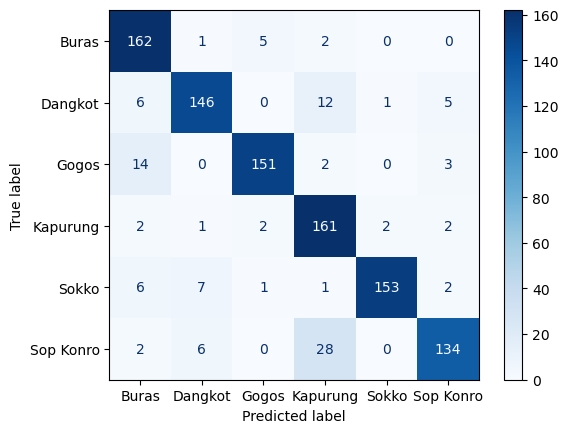

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Path dataset uji
test_dir = r"D:\Kuliah Semester 6\Jurnal\Materi\CNN\Split_dataset\test"

# Load model yang sudah dilatih
model = tf.keras.models.load_model("D:\Kuliah Semester 6\Jurnal\Materi\CNN\Codingan\Model_Skripsi\mobilenetv2_Percobaan 4(2).h5")

# Load data uji
img_size = (224, 224)  # Sesuaikan dengan ukuran input model
batch_size = 32  # Sesuaikan dengan batch size yang digunakan

test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Normalisasi pixel
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # Penting agar urutan label sesuai
)

# Prediksi menggunakan model
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)  # Konversi probabilitas ke label kelas
y_true = test_generator.classes  # Label asli dari test dataset

# Buat Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Tampilkan Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap="Blues")
plt.show()



Deteksi

In [ ]:
import os
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import time

# Load the custom MobileNetV2 model
model = load_model("D:\Kuliah Semester 6\Jurnal\Materi\CNN\Codingan\model\mobilenetv2_Percobaan 4(2).h5")

# Define the class names
class_names = ['Buras', 'Dangkot', 'Gogos', 'Kapurung', 'Sokko', 'Sop Konro']

# Define the folder containing your images
image_folder = r"D:\Kuliah Semester 6\Jurnal\Materi\Modul1\yolo7-cpu\inference\images"

# Get a list of image files in the folder
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

# Select the first 24 images
image_files = image_files[:24]

# Start the timer
start_time = time.time()

for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))  # Sesuaikan ukuran dengan ukuran input model Anda
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Make prediction
    preds = model.predict(x)

    # Get the index of the highest probability prediction
    pred_index = np.argmax(preds)

    # Initialize the predicted class variable
    predicted_class = "Predicted index is out of range"

    # Check if pred_index is within the range of class_names
    if pred_index < len(class_names):
        # Get the predicted class label
        predicted_class = class_names[pred_index]

    # Print the predicted class label
    print(f"Image: {image_file} - Predicted class: {predicted_class}")

# Stop the timer
end_time = time.time()

# Calculate the total time taken
total_time = end_time - start_time
print(f"Total time for detecting 24 images: {total_time} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Image: BURAS_1059.jpg - Predicted class: Buras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Image: BURAS_110.jpg - Predicted class: Buras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Image: BURAS_813.jpg - Predicted class: Buras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Image: BURAS_867.jpg - Predicted class: Buras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Image: DANGKOT_13.jpg - Predicted class: Dangkot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Image: DANGKOT_4.jpg - Predicted class: Dangkot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Image: DANGKOT_741.jpg - Predicted class: Dangkot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Image: DANGKOT_892.jpg - Predicted class: Dangkot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Image: GOGOS_126.jpg - Predicted class: Gogos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Image: GOGOS_156.jpg - Predicted class: Gogos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image: GOGOS_173.jpg - Predicted class: Gogos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Image: GOGOS_418.jpg - Pr